In [248]:
%matplotlib inline
import pandas as pd
import IGtools as igt
import networkx as nx
import os, sys 
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from tqdm import tqdm_notebook

In [249]:
import igraph as ig

In [250]:
def plot_results(x,data,norm=None,label=None,marker='s'):
    yy = map(lambda x: np.mean(data[x]), sorted(data.keys()));
    std_yy = map(lambda x: np.std(data[x]), sorted(data.keys()));
    plt.gca()
    if norm==None:
        plt.errorbar(x, np.array(yy), np.array(std_yy), fmt=marker,ms=10,alpha=0.6, label=label);
    else:
        plt.errorbar(x, np.array(yy)/float(norm), np.array(std_yy)/float(norm), fmt=marker,ms=10,alpha=0.6, label=label);
    return;

In [251]:
from scipy.optimize import fsolve, fmin, root
import sympy as sy
from mis_utils import *

# Simulation-driven comparison with IG 

In [252]:
num_iter = 10;
nN = 20;
xs = np.linspace(0.0001, 1, 2000); #lazy xs

new_res_ig = {};
new_av_k_ig = {}
new_n_ig_dict = {}
new_gauss_pred = {}

In [354]:
def rho_generic(x,d,pk,c):
    M = eval_genfunc(pk, np.log(x));
    Mprime =  eval_genfunc_prime(pk, np.log(x));
    mod = M - Mprime;
    return (d/c)  * (1 - np.power(x,c/float(c-1))) + mod;

# def rho_generic(x,d,pk,c):
#     M = eval_genfunc(pk,x);
#     Mprime = eval_genfunc_prime(pk,x);
#     mod = M - Mprime;
#     return (d/c)  * (1 - np.power(x,c/float(c-1))) + mod;

def eval_genfunc(pk,x):
    tot = np.sum(pk.values())
    return np.sum([(pk[k]/float(tot)) * np.power(x, k) for k in pk]);

def eval_genfunc_prime(pk,x):
    tot = np.sum(pk.values())
    return np.sum([k*(pk[k]/float(tot)) * np.power(x, k-1) for k in pk if k>0]);    


# def attempt_scipy_func_generic(x, d, pk, c):
#     return np.abs(x - np.power(1 - (eval_genfunc_prime(pk, np.log(x)) / float(d*x)), c-1));

def attempt_scipy_func_generic(x, d, pk, c):
    return np.abs(x - np.power(1 - (eval_genfunc_prime(pk, np.log(x)) / float(d*x)), c-1));


def minimize_pstar_generic(xs, d, pk, c):
    vals = map(lambda x: attempt_scipy_func_generic(x, d, pk, c), xs);
    x0 = (np.min(vals), xs[np.nanargmin(vals)])
    return x0[1]

/anaconda3/envs/py2/lib/python2.7/site-packages/ipykernel_launcher.py:24: OptimizeWarning: Unknown solver options: xtol


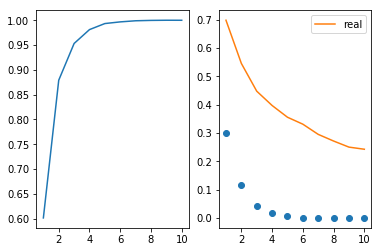

In [360]:
from scipy.optimize import minimize
from scipy.stats import bernoulli, poisson

ress = []
rhos = []
mis = []
basis = np.linspace(1,10,10)
for k in basis:
    deh = poisson(k);
    data = deh.rvs(2000)
    try:
        g = nx.configuration_model(data)
    except:
        data[0]-=1;
        g = nx.configuration_model(data)
    g.remove_edges_from(g.selfloop_edges())
    data = g.degree().values()
    pk = Counter(data)
    z = np.mean(data)
    def rosen(x):
        return attempt_scipy_func_generic(x, z, pk, c);

    x0 = .1
    res = minimize(rosen, x0, method='BFGS', options={'xtol': 1e-8})#, 'disp': True});
    ress.append(res.x);
    
    rhos.append(rho_generic(res.x,z,pk,c))
    mis.append(len(nx.maximal_independent_set(g)));
plt.subplot(121)
plt.plot(basis, ress)
plt.subplot(122)
plt.plot(basis, rhos, 'o')
plt.plot(basis, np.array(mis)/2000.0, label='real')
plt.legend()

/anaconda3/envs/py2/lib/python2.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log


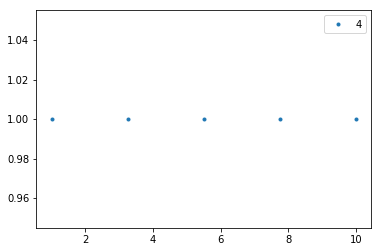

In [356]:
c = 2
pss = np.linspace(1,10,5)
kks = [k*pk[k] for k in pk];
z = np.sum(kks)/np.sum(pk.values())
xs = np.linspace(0,1,5000);
plt.plot(pss, map(lambda x: minimize_pstar_generic(xs, x, pk,c), pss),'.', label = '4')
# plt.plot(pss, map(lambda x: minimize_pstar_generic(xs, x, 3,c), pss),'.', label = '3')
# plt.plot(pss, map(lambda x: minimize_pstar_generic(xs, x, 2,c), pss),'.', label = '2')
# plt.plot(pss, map(lambda x: minimize_pstar_generic(xs, x, 1.5,c), pss),'.', label = '1.5')
# plt.plot(pss, map(lambda x: minimize_pstar_generic(xs, x, 1,c), pss),'.', label = '1')
plt.legend(loc=0)

In [231]:
import time
from datetime import datetime

import igraph as igg
new_k_min = 2
new_k_max = 8
new_pmin = new_k_min/float(nN);
new_pmax = new_k_max/float(nN);
# precision = 30
# new_ps = np.linspace(new_pmin,new_pmax,precision);
new_ps = range(new_k_min,new_k_max,2);

from scipy.stats import norm
from collections import Counter
for l,p in tqdm_notebook(enumerate(new_ps)):
    print l, '/', len(new_ps), ':', p, 'started:', str(datetime.now())
    new_gauss_pred[p] = []
    new_res_ig[p] = []
    new_av_k_ig[p] = [];
    new_n_ig_dict[p] = []
    for it in range(num_iter):
        g = nx.powerlaw_cluster_graph(nN,p,0.1);
        GC = sorted(nx.connected_components(g), key = len, reverse=True)[0] 
        g = nx.subgraph(g,GC)
        g = igt.create_configuration_model_graph(nx.degree(g).values())
        lg = igt.line_graph(g) # create line graph
        ig = igt.interference_graph(lg) # create interference graph
        degs = ig.degree().values()
        pk = Counter(degs);
        new_av_k_ig[p].append(np.mean(degs)); # computed z
        new_n_ig = ig.number_of_nodes() # compute number of tasks M
        new_n_ig_dict[p].append(new_n_ig); # compute number of tasks M
        nx.write_gml(ig,'test.gml'); #horrible trick
        g_igraph = igg.load('test.gml') 
        new_res_ig[p].append( g_igraph.alpha() )  # empirical/real MIS size
#         p_star = minimize_pstar_generic(xs, new_av_k_ig[p][-1], pk, 2)

        def rosen(x):
            return attempt_scipy_func_generic(x, new_av_k_ig[p][-1], pk, 2);

        x0 = 0.1
        res = minimize(rosen, x0, method='BFGS', options={'xtol': 1e-8})#, 'disp': True});
        new_gauss_pred[p].append(rho_generic(res.x,new_av_k_ig[p][-1],pk,2))# rho_generic(p_star, new_av_k_ig[p][-1], pk, 2) )

0 / 3 : 2 started: 2019-10-08 18:35:54.820948


/anaconda3/envs/py2/lib/python2.7/site-packages/ipykernel_launcher.py:42: OptimizeWarning: Unknown solver options: xtol


1 / 3 : 4 started: 2019-10-08 18:36:01.936050
2 / 3 : 6 started: 2019-10-08 18:36:40.129795


In [232]:
np.array(new_res_ig[p]) / np.array(map(float,new_n_ig_dict[p]))

array([0.05925926, 0.0530303 , 0.05072464, 0.05109489, 0.05035971,
       0.05925926, 0.04929577, 0.04827586, 0.05      , 0.04964539])

In [233]:
cmap = plt.cm.hot
cmaplist = [cmap(i) for i in range(cmap.N)]
cmap = cmap.from_list('Custom cmap', cmaplist, cmap.N)

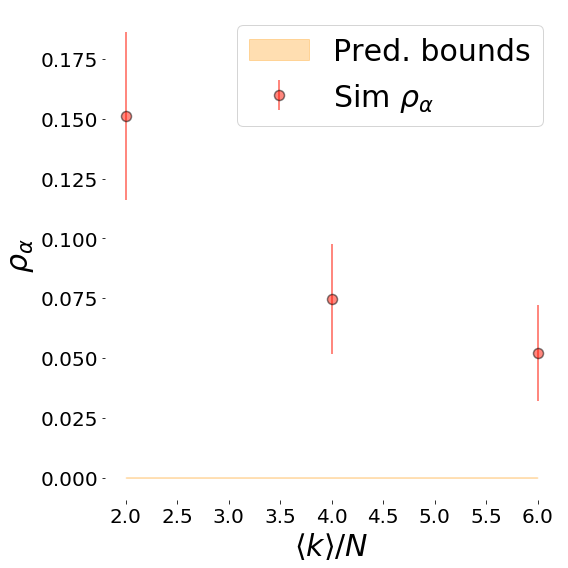

In [234]:
fs = 30
fig = plt.figure(figsize=(8,8))
data = new_gauss_pred
yy = np.array(map(lambda x: np.mean(data[x]), sorted(data.keys())));
std_yy = np.array(map(lambda x: np.std(data[x]), sorted(data.keys())));
plt.fill_between(new_ps,yy+std_yy,yy-std_yy, alpha=0.3,color=cmap(150), label='Pred. bounds')

data = new_res_ig
yy = map(lambda x: np.mean(data[x])/np.mean(new_n_ig_dict[x]), sorted(data.keys()));
std_yy = map(lambda x: np.std(data[x])/nN, sorted(data.keys()));
plt.errorbar(new_ps,yy,std_yy, ms=20,alpha=0.5,color=cmap(100),fmt='.',lw=2,mew=1.5,mec='k',label = r'Sim $\rho_\alpha$')
plt.ylabel(r'$\rho_\alpha$', fontsize=fs)
plt.xlabel(r'$\langle k \rangle/N$', fontsize=fs)
plt.box('off')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(loc=0, fontsize=30)
plt.tight_layout()

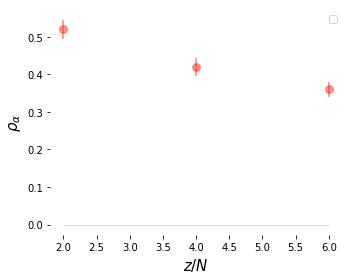

In [9]:
fs = 15
fig = plt.figure(figsize=(5,4))
data = new_gauss_pred
yy = np.array(map(lambda x: np.mean(data[x]), sorted(data.keys())));
std_yy = np.array(map(lambda x: np.std(data[x]), sorted(data.keys())));
plt.fill_between(new_ps,yy+std_yy,yy-std_yy, alpha=0.3,color=cmap(150))

data = new_res_ig
yy = map(lambda x: np.mean(data[x])/nN, sorted(data.keys()));
std_yy = map(lambda x: np.std(data[x])/nN, sorted(data.keys()));
plt.errorbar(new_ps,yy,std_yy, ms=15,alpha=0.4,color=cmap(100),fmt='.',lw=2,mew=1.5)#,label = n_sigma)
plt.ylabel(r'$\rho_\alpha$', fontsize=fs)
plt.xlabel(r'$z/N$', fontsize=fs)
plt.box('off')
plt.legend(loc=0)
plt.tight_layout()

In [10]:
# #density calculation 
# new_k_min = 1
# new_k_max = 15
# new_pmin = new_k_min/float(nN);
# new_pmax = new_k_max/float(nN);
# precision = 30
# new_ps = np.linspace(new_pmin,new_pmax,precision);
# ts_dens = {}
# dens = {}
# for l,p in tqdm_notebook(enumerate(new_ps)):
#     dens[p] = []
#     ts_dens[p] = []
#     for it in range(num_iter):
#         g = igt.create_ER_bipartite_graph(nN,p) # create ER bipartite graph
#         ts_dens[p].append(nx.density(g));
#         lg = igt.line_graph(g) # create line graph
#         ig = igt.interference_graph(lg) # create interference graph
#         dens[p].append(nx.density(ig));

In [11]:
av_dens = [np.mean(dens[x]) for x in new_ps]
# ts_av_dens = [np.mean(ts_dens[x]) for x in new_ps]

ValueError: operands could not be broadcast together with shapes (30,) (3,) 

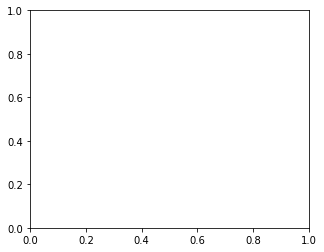

In [12]:
fs = 15
fig = plt.figure(figsize=(5,4))
ax = plt.subplot(111)
data = new_gauss_pred
yy = np.array(map(lambda x: np.mean(data[x]), sorted(data.keys())));
std_yy = np.array(map(lambda x: np.std(data[x]), sorted(data.keys())));
plt.fill_between(new_ps,yy+std_yy,yy-std_yy, alpha=0.3,color=cmap(150))

data = new_res_ig
yy = map(lambda x: np.mean(data[x])/nN, sorted(data.keys()));
std_yy = map(lambda x: np.std(data[x])/nN, sorted(data.keys()));
plt.errorbar(new_ps,yy,std_yy, ms=0,alpha=0.4,color=cmap(av_dens),fmt='.',lw=2,mew=1.5)#,label = n_sigma)
plt.scatter(new_ps, yy, c=cmap(av_dens))
plt.ylabel(r'$\rho_\alpha$', fontsize=fs)
plt.xlabel(r'$z/N$', fontsize=fs)
plt.box('off')
plt.legend(loc=0)
plt.tight_layout()


In [ ]:
plt.plot(ts_av_dens)